In [1]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical
from keras.preprocessing import image
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from prettytable import PrettyTable

In [2]:
rootPath = './spectrograms2/Full/'
imgPath = 'test/'
testImgPath = rootPath + imgPath + os.listdir(rootPath + imgPath)[0]
res = [cv2.imread(testImgPath).shape[0], cv2.imread(testImgPath).shape[1]]

print('Current Resolution: \t' + str(res))

#res = [int(res[0]/2), int(res[1]/2)]
#print('New Resolution: \t' + str(res))

#res = [int(res[0]/1.5), int(res[1]/1.5)]
#print('New Resolution: \t' + str(res))

res = [int(res[0]/4), int(res[1]/4)]
print('New Resolution: \t' + str(res))

Current Resolution: 	[540, 1080]
New Resolution: 	[135, 270]


In [3]:
width_shift = 3/32
height_shift = 3/32
flip = True

#train = ImageDataGenerator(
#    horizontal_flip=flip,
#    width_shift_range=width_shift,
#    height_shift_range=height_shift,
#    rescale=1/255
#    )


#validation = ImageDataGenerator(
#    horizontal_flip=flip,
#    width_shift_range=width_shift,
#    height_shift_range=height_shift,
#    rescale=1/255
#    )

train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

In [4]:
train_dataset = train.flow_from_directory(
    rootPath + 'train/',
    target_size = (res[0], res[1]),
    batch_size = 32,
    class_mode = 'categorical'
)

validation_dataset = validation.flow_from_directory(
    rootPath + 'validate/',
    target_size = (res[0], res[1]),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1440 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


In [5]:
#print(train_dataset.class_indices)
#print(validation_dataset.class_indices)

# train generator (rotate images)

train_datagen = ImageDataGenerator(rotation_range=45,
    width_shift_range=0.2,
    zoom_range = 0.2,
    horizontal_flip = True)
train_datagen.fit(train_dataset)

train_generator = train_datagen.flow(
    train_dataset,
    batch_size = 32)

In [6]:
# model
activation = 'relu'
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation=activation, input_shape=(res[0], res[1], 3)),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(32,(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(64,(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    #
    tf.keras.layers.Conv2D(64,(3,3), activation=activation),
    tf.keras.layers.MaxPool2D(2,2),
    ##
    tf.keras.layers.Flatten(),
    ##
    tf.keras.layers.Dense(512, activation=activation),
    ##
    tf.keras.layers.Dense(12, activation='sigmoid')  
])

activation = 'sigmoid'
model = Sequential()
model.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (res[0], res[1], 3)))
model.add(BatchNormalization())

model.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization())

model.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation = activation, kernel_initializer = 'he_uniform'))
model.add(Dense(1, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())

In [7]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(lr=0.001),
    metrics=['accuracy']
)

In [8]:
model_fit = model.fit(
    train_dataset,
    steps_per_epoch=45,
    epochs=100,
    validation_data=validation_dataset
)

Epoch 1/100


In [10]:
def resultStore(file, pred, results):
    pred = pred.lower()
    if pred in file:
        results[0] = 'PASS'
        results[1] = results[1] + 1
    else:
        results[0] = 'FAIL'
        results[2] = results[2] + 1
    return results

def resultStats(results):
    total = results[1] + results[2]
    p = round(results[1]*100/total, 2)
    f = round(results[2]*100/total, 2)
    return 'Pass: ' + str(p) + '% (' + str(results[1]) + '), Fail: ' + str(f) + '% (' + str(results[2]) + '), Total: ' + str(total)

In [11]:
validation_dataset.class_indices
classes = {v: k for k, v in validation_dataset.class_indices.items()}
print(classes)

{0: 'clean-0-0-10', 1: 'clean-0-10-0', 2: 'clean-10-0-0', 3: 'clean-5-5-5', 4: 'lead-0-0-10', 5: 'lead-0-10-0', 6: 'lead-10-0-0', 7: 'lead-5-5-5', 8: 'rhythm-0-0-10', 9: 'rhythm-0-10-0', 10: 'rhythm-10-0-0', 11: 'rhythm-5-5-5'}


testPath = rootPath + 'test/'
results = ["", 0, 0]

table = PrettyTable()
table.field_names = ["1", "File", "2", "Class", "3", "Prediction", "4", "Result", " "]

for i in os.listdir(testPath):
    img = image.load_img(
        testPath + '//' + i,
        target_size = (res[0], res[1])
    )

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])
    prediction = int(model.predict(images))
    
    results = resultStore(i, classes[prediction][3:-4], results)
    splt = i.split('_session_')
    clss = splt[0]
    fname = splt[1].replace('_', ' ')
    table.add_row(["", fname[:-4], "", clss, "", classes[prediction][3:-4], "", results[0], ""])

table.align = 'l'
print(table)

print('\n' + resultStats(results))

In [23]:
def get_precision(prec, result, clss):
    if result == "PASS":
        prec[clss][0] = prec[clss][0] + 1
        prec[clss][1] = prec[clss][1] + 1
    else:
        prec[clss][1] = prec[clss][1] + 1
    return prec

def get_recall(rec, result, pred_clss, real_clss):
    if result == "PASS":
        rec[pred_clss][0] = rec[pred_clss][0] + 1
        rec[pred_clss][1] = rec[pred_clss][1] + 1
    else:
        rec[get_class_index(real_clss)][1] = rec[get_class_index(real_clss)][1] + 1

    return rec

def get_class_index(real_clss):
    for i in classes:
        if classes[i] == real_clss:
            return i

def get_fscore(prec, rec):
    return round((2 * ((prec * rec) / (prec + rec)))/100, 2)

def get_metrics(precision, recall, classes):

    metrics_table = PrettyTable()
    metrics_table.field_names = ["Class", "Precision", "Recall", "F-Score"]

    for i in classes:
        try:
            prec = round((precision[i][0]/precision[i][1]), 2)*100
            rec = round((recall[i][0]/recall[i][1]), 2)*100
            fscore = get_fscore(prec, rec)
        except:
            prec = 0.0
            rec = round((recall[i][0]/recall[i][1]), 2)*100
            fscore = 0.0

        metrics_table.add_row([classes[i], prec, rec, fscore])


    return metrics_table

In [24]:
recall = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
precision = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]

testPath = rootPath + 'test/'
results = ["", 0, 0]

table = PrettyTable()
table.field_names = ["File", "Class", "Prediction", "Result"]

for i in os.listdir(testPath):
    img = image.load_img(
        testPath + '//' + i,
        target_size = (res[0], res[1])
    )

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])

    #print(model.predict(images)[0])

    predictions = model.predict(images)[0]
    #prediction = 0

    for j in range(len(predictions)):
        if predictions[j] != 0:
            prediction = j
            break
    
    results = resultStore(i, classes[prediction], results)
    splt = i.split('_session_')
    clss = splt[0]
    fname = splt[1].replace('_', ' ')
    table.add_row([fname[:-4] + "    ", clss + "    ", classes[prediction] + "    ", results[0] + "    "])

    precision = get_precision(precision, results[0], prediction)
    recall = get_recall(recall, results[0], prediction, clss)

table.align = 'l'
print(table)

print('\n' + resultStats(results))

print(get_metrics(precision, recall, classes))

+-----------------------------+-------------------+-------------------+----------+
| File                        | Class             | Prediction        | Result   |
+-----------------------------+-------------------+-------------------+----------+
| 2 Minutes To Midnight 2     | clean-0-0-10      | clean-0-0-10      | PASS     |
| 2 Minutes To Midnight       | clean-0-0-10      | clean-0-0-10      | PASS     |
| 8 Strings Low 2             | clean-0-0-10      | clean-0-0-10      | PASS     |
| 8 Strings Low               | clean-0-0-10      | clean-0-0-10      | PASS     |
| Audio 41                    | clean-0-0-10      | clean-0-0-10      | PASS     |
| Audio 42                    | clean-0-0-10      | clean-0-0-10      | PASS     |
| Audio 43                    | clean-0-0-10      | clean-0-0-10      | PASS     |
| Audio 44                    | clean-0-0-10      | clean-0-0-10      | PASS     |
| Audio 45                    | clean-0-0-10      | clean-0-0-10      | PASS     |
| Au

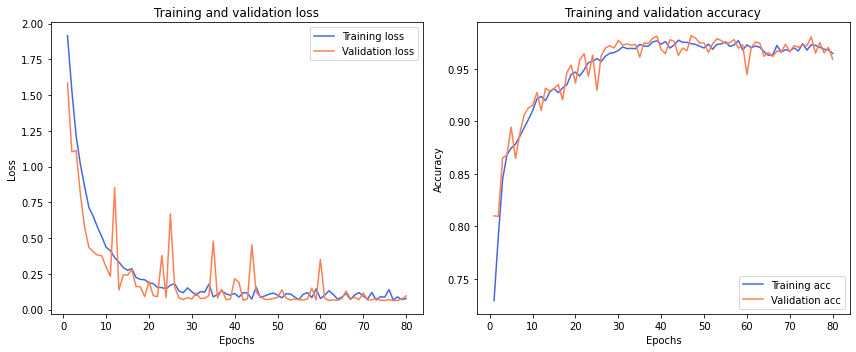

In [38]:
#plot the training and validation accuracy and loss at each epoch
plt.subplot(1, 2, 1)
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'royalblue', label='Training loss')
plt.plot(epochs, val_loss, 'coral', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, 'royalblue', label='Training acc')
plt.plot(epochs, val_acc, 'coral', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.rcParams['figure.figsize'] = [12, 5]
plt.tight_layout()
plt.savefig("test.pdf", format="pdf")
plt.show()

In [14]:
#model.save('12-classes.h5')